In [1]:
import sys
import os
sys.path.append('../')
import numpy as np
import scipy.signal as sps
from source.reader import read_raw
from source.interference_reject import InterferenceReject
from source.utils import compute_kspace_weights, compute_welch
import matplotlib.pyplot as plt
import plotly  as py
import plotly.graph_objects as go
%matplotlib inline

In [17]:
# Data import
file_name = "/Users/had-mr/github/data_interference/data/fid_brain_ecg.h5"
data, index, metadata = read_raw(file_name)
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
select_channels_signal = np.arange(num_channels_signal)
select_channels_noise = np.arange(num_channels_signal, num_channels_all)
matrix_size = metadata['sequence']['encoding']['matrix_size']
acq_bandwidth = metadata['sequence']['readout']['readouts'][0]['bandwidth']

In [18]:
interf_rej = InterferenceReject(channels_signal=select_channels_signal,channels_noise=select_channels_noise)
data_signal_raw = data['scan']
data_signal_cor = interf_rej.apply(data_signal=data_signal_raw, data_noise=data['noise'])
# Also get prescan-corrected data
data_prescan_cor = interf_rej.apply(data_signal=data['noise'], data_noise=data['noise'])
# Pre-scan corrected data without e-sensor
interf_rej_no_es = InterferenceReject(channels_signal=select_channels_signal,channels_noise=select_channels_noise[1:])
data_prescan_no_es = interf_rej_no_es.apply(data_signal=data['noise'], data_noise=data['noise'])

## Plot NMR lines

In [19]:
spec_signal_cor = np.fft.fftshift(np.fft.fft(data_signal_cor, axis=-1), axes=-1)
spec_signal_raw = np.fft.fftshift(np.fft.fft(data_signal_raw, axis=-1), axes=-1)
axis_freq = 1e-3 * np.linspace(-0.5 * acq_bandwidth, 0.5 * acq_bandwidth, spec_signal_raw.shape[-1])
axis_time = 1e3 * np.arange(spec_signal_raw.shape[-1]) / acq_bandwidth

ch = 3

# Interactive plot
fig = go.Figure()
fig.update_layout(plot_bgcolor="white")
line_style = {'color': 'orange', 'width': 2}
fig.add_trace(go.Scatter(x=axis_freq, y=np.abs(spec_signal_raw[0, ch, :]), line=line_style, name='Raw'))
line_style = {'color': 'blue', 'width': 2}
fig.add_trace(go.Scatter(x=axis_freq, y=np.abs(spec_signal_cor[0, ch, :]), line=line_style, name='Corrected'))
fig.show()

## Plot noise density (prescan)

In [20]:
axis_pow, pow_raw = compute_welch(data['noise'][:, :num_channels_signal, :], acq_bandwidth, 1)
axis_pow, pow_cor = compute_welch(data_prescan_cor, acq_bandwidth, 1)
axis_pow, pow_cor_no_es = compute_welch(data_prescan_no_es, acq_bandwidth, 1)

# Print ratio in dB
print("Average rejection: {} dB".format(10 * np.log(np.mean(pow_raw / pow_cor))))
print("Max rejection: {} dB".format(10 * np.log(np.max(pow_raw / pow_cor))))
print("Average e-sensor: {} dB".format(10 * np.log(np.mean(pow_cor_no_es / pow_cor))))
print("Max e-sensor: {} dB".format(10 * np.log(np.max(pow_cor_no_es / pow_cor))))

# Interactive plot
fig = go.Figure()
fig.update_layout(plot_bgcolor="white")
line_style = {'color': 'orange', 'width': 2}
fig.add_trace(go.Scatter(x=axis_pow, y=10 * np.log(pow_raw[ch, :]), line=line_style, name='Raw'))
line_style = {'color': 'gray', 'width': 2}
fig.add_trace(go.Scatter(x=axis_pow, y=10 * np.log(pow_cor_no_es[ch, :]), line=line_style, name='Noise coils only'))
line_style = {'color': 'blue', 'width': 2}
fig.add_trace(go.Scatter(x=axis_pow, y=10 * np.log(pow_cor[ch, :]), line=line_style, name='Noise coils + e-sensor'))
fig.show()


Average rejection: 82.85786610584567 dB
Max rejection: 132.84953591517097 dB
Average e-sensor: 2.6846297394951013 dB
Max e-sensor: 14.551577816246827 dB


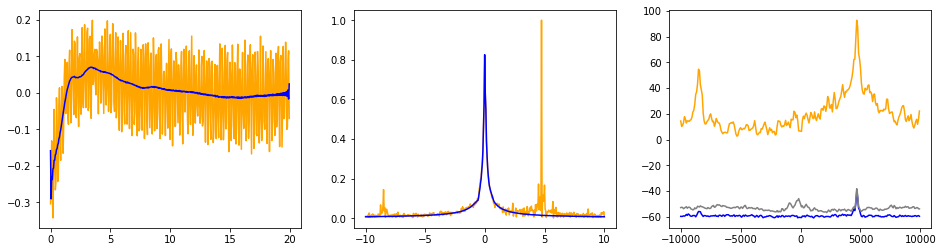

In [21]:
# Paper figure
spec_max = np.max(np.abs(spec_signal_raw[0, ch, :]))
fid_max = np.max(np.abs(data_signal_raw[0, ch, :]))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
# FID
ax[0].plot(axis_time, np.real(data_signal_raw[0, ch, :])/fid_max, 'orange')
ax[0].plot(axis_time, np.real(data_signal_cor[0, ch, :])/fid_max, 'blue')
# Signal spectrum
ax[1].plot(axis_freq, np.abs(spec_signal_raw[0, ch, :])/spec_max, 'orange')
ax[1].plot(axis_freq, np.abs(spec_signal_cor[0, ch, :])/spec_max, 'blue')
# Noise power
ax[2].plot(axis_pow, 10 * np.log(pow_raw[ch, :]), 'orange')
ax[2].plot(axis_pow, 10 * np.log(pow_cor[ch, :]), 'blue')
ax[2].plot(axis_pow, 10 * np.log(pow_cor_no_es[ch, :]), 'gray')
# fig.savefig("fid_correction.tif", dpi=600, format="tiff")
dir_data, file_data = os.path.split(file_name)
dir_fig = os.path.join(dir_data, "figures_power")
if not os.path.isdir(dir_fig):
    os.mkdir(dir_fig)
file_fig = os.path.splitext(file_data)[0] + ".png"
fig.savefig(os.path.join(dir_fig, file_fig))
# fig.savefig("fid_correction.tif", dpi=600, format="tiff")
